In [1]:
import kagome, qiskit
import numpy as np
import matplotlib.pyplot as plt

startTime = kagome.strtime()
print(f"Start at {startTime}\n")
qVersion=kagome.init_notebook(output=True)

import qiskit.tools.jupyter
%qiskit_version_table

Start at Thu Feb  9 22:02:12 2023 UTC

qTools: myTools(major=1, minor=1, micro=0)
Qiskit: <dict>
    qiskit-terra : 0.22.4
    qiskit-aer : 0.11.2
    qiskit-ignis : 0.7.1
    qiskit-ibmq-provider : 0.19.2
    qiskit : 0.39.5
    qiskit-nature : 0.5.2
    qiskit-finance : 0.3.4
    qiskit-optimization : 0.4.0
    qiskit-machine-learning : None



In [2]:
# Setup Account, Provider, Service and Backends
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)

provider, service = kagome.get_provider(channel='ibm_quantum',
                                        hub='ibm-q', group='open', project='main',
                                        output=True,   # Print out the available backends
                                       )

from qiskit.providers.fake_provider import FakeGuadalupe
guadalupeSim     = FakeGuadalupe()
simulator        = provider.get_backend('simulator_statevector')
nairobi          = provider.get_backend('ibm_nairobi')
oslo             = provider.get_backend('ibm_oslo')

Available backends
	ibmq_belem
	simulator_mps
	ibmq_manila
	ibm_oslo
	ibmq_qasm_simulator
	ibmq_quito
	ibmq_lima
	simulator_extended_stabilizer
	simulator_statevector
	simulator_stabilizer
	ibm_nairobi


In [3]:
# Import Solution Utilities
import matplotlib.pyplot as plt
import numpy             as np
import rustworkx         as rx

from time import time
from heisenberg_model import HeisenbergModel

from qiskit import transpile, QuantumCircuit
from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms import NumPyEigensolver

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

# Develop Lattices

In [197]:
# Define edge lists for the lattices
t = 1    # All are weighted equally to start
edges_sq = [(0,1,t),(1,2,t),(2,3,t),(3,0,t)]
edges_3 = [(0, 1, t),(0, 2, t),(2, 1, t),]
edges_4 = [(0, 1, t),(0, 2, t),(2, 1, t),(1, 3, t),]
edges_5 = [(0, 1, t),(0, 2, t),(2, 1, t),(1, 3, t),(3, 4, t),(1, 4, t)]
edges_12 = [(0, 1, t), (0, 2, t),  (1, 2, t),  (1, 3, t),   (1, 4, t),  (3, 4, t),
            (4, 5, t), (4, 6, t),  (5, 6, t),  (5, 7, t),   (5, 8, t),  (7, 8, t),
            (7, 9, t), (7, 10, t), (9, 10, t), (10, 11, t), (10, 0, t), (11, 0, t) ]
edges_16 = [(1, 2, t),(2, 3, t),(3, 5, t),(5, 8, t),(8, 11, t),(11, 14, t),(14, 13, t),
            (13, 12, t),(12, 10, t),(10, 7, t),(7, 4, t),(4, 1, t),(4, 2, t),(2, 5, t),
            (5, 11, t),(11, 13, t),(13, 10, t),(10, 4, t),]        

# Specify node locations for better visualizations
pos16 = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1],
          1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
          13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
          8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
pos_sq  = { 0:pos16[13], 1:pos16[4], 2:pos16[2], 3:pos16[11], }
pos7_sq = { 0:pos16[13], 1:pos16[4], 2:pos16[2], 3:pos16[11],
            4:[0.5,-1], 5:[1.0,-1], 6:[1.5,-1], }
pos3    = { 0:pos16[13], 1:pos16[10], 2:pos16[12],
            3:[0.5,-1],  4:[0.75,-1], 5:[1.0,-1],  6:[1.25,-1],}
pos4    = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:pos16[7], }
pos4a   = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:[pos4[1][0],pos4[3][1]], }
pos5    = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:pos16[7],
            4:pos16[4], }
pos7    = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:[pos4[1][0],pos4[3][1]],
            4:[0.5,-1],  5:[0.75,-1], 6:[1.0,-1]}
pos12   = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:pos16[7],
            4:pos16[4],  5:pos16[2],  6:pos16[1],  7:pos16[5],
            8:pos16[3],  9:pos16[8], 10:pos16[11], 11:pos16[14]}

# Mapping lattice node to device qubits
qbitmap_12_to_16 = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4] # for guadalupe and FakeGuadalupe
qbitmap_4_to_7   = [0,1,2,3]    # For nairobi and oslo
qbitmap_3_to_7   = [0,1,2]      # For nairobi and oslo

# Create Lattices

## Full Lattice  (12 and 16 node versions)

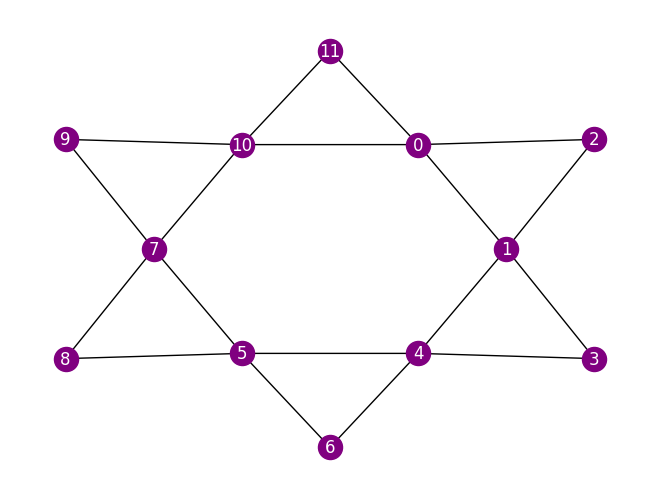

In [5]:
cell_12 = kagome.create_lattice(12,edges_12)
kagome.draw_lattice(cell_12,pos12)

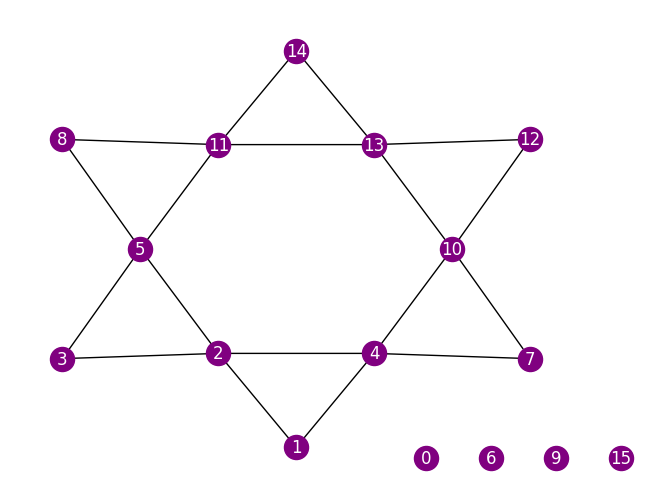

In [6]:
cell_16 = kagome.create_lattice(16,edges_16)
kagome.draw_lattice(cell_16,pos16)

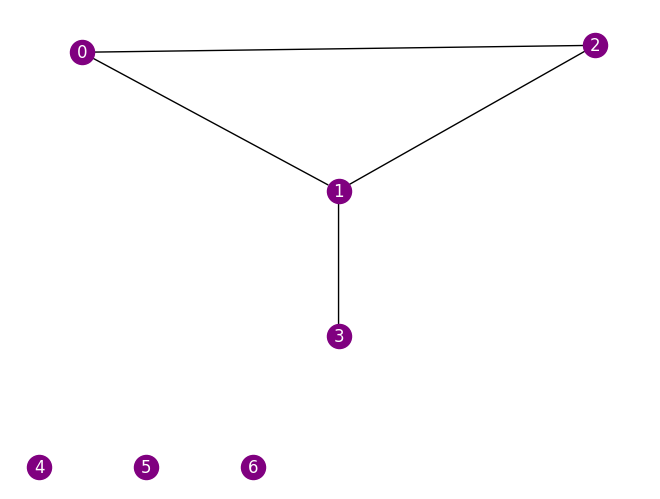

In [7]:
cell_7 = kagome.create_lattice(7,edges_4)
kagome.draw_lattice(cell_7,pos7)

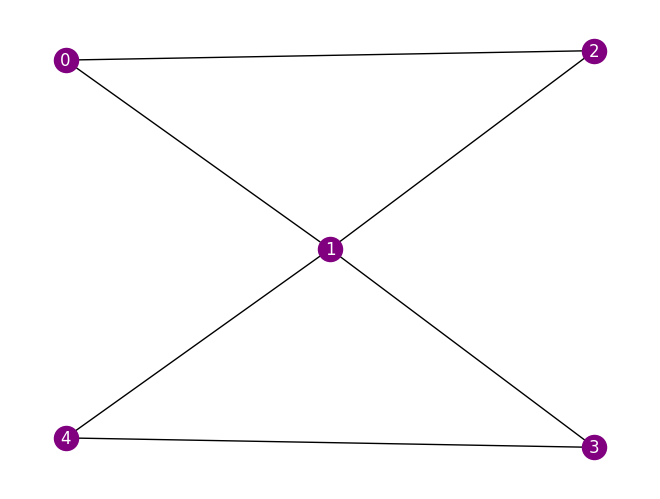

In [8]:
cell_5 = kagome.create_lattice(5,edges_5)
kagome.draw_lattice(cell_5,pos5)

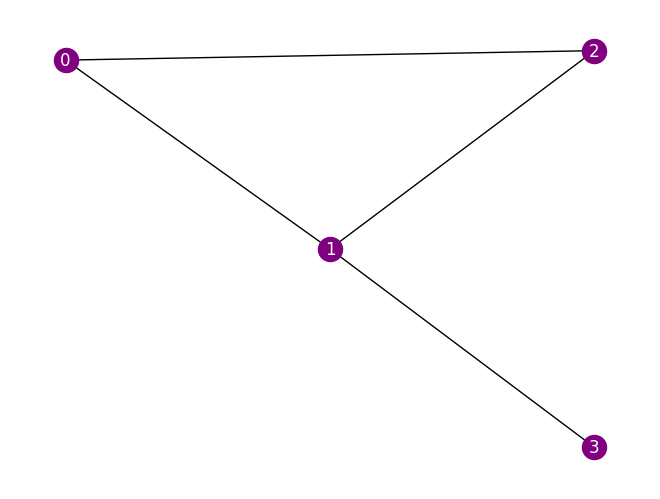

In [292]:
cell4_4 = kagome.create_lattice(4,edges_4)
kagome.draw_lattice(cell4_4,pos4)

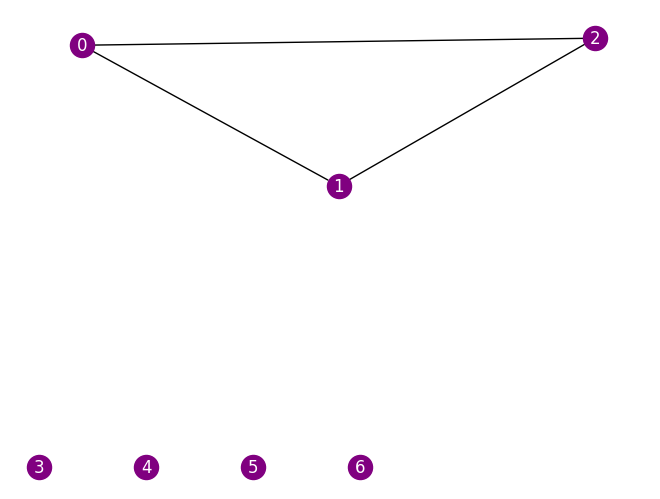

In [253]:
cell3_3 = kagome.create_lattice(3,edges_3)
cell3_7 = kagome.create_lattice(7,edges_3)

kagome.draw_lattice(cell_3_7,pos3)

4


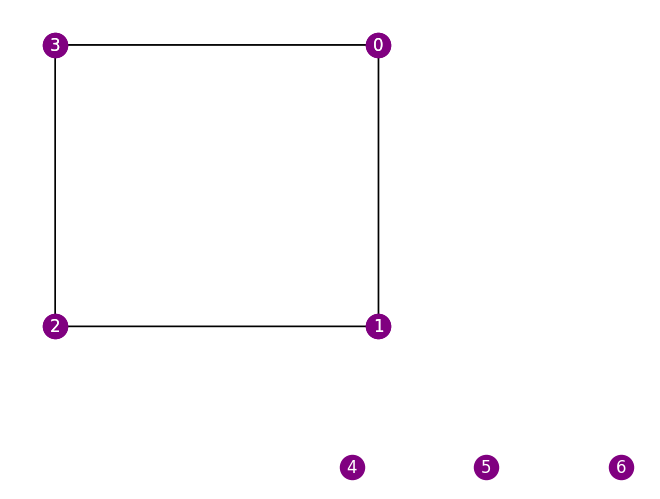

In [308]:
cell4_sq = kagome.create_lattice(4,edges_sq)
kagome.draw_lattice(cell_sq,pos_sq)
cell7_sq = kagome.create_lattice(7,edges_sq)
kagome.draw_lattice(cell7_sq,pos7_sq)

## Build Hamiltonians

In [430]:
hams = {}
cell_list = {}
cell_list['12_12'] = cell_12
cell_list['12_16'] = cell_16
cell_list['4_7']   = cell_7
cell_list['4_4']   = cell4_4
cell_list['3_3']   = cell3_3
cell_list['sq_4']  = cell4_sq
cell_list['sq_7']  = cell7_sq


H12 = hams['12_12']  = kagome.get_hamiltonian(cell_12)
H16 = hams['12_16']  = kagome.get_hamiltonian(cell_16)
H7  = hams['4_7']    = kagome.get_hamiltonian(cell_7)
H4  = hams['4_4']    = kagome.get_hamiltonian(cell4_4)
H3  = hams['3_3']    = kagome.get_hamiltonian(cell3_3)
H4_sq = hams['sq_4'] = kagome.get_hamiltonian(cell4_sq)
H7_sq = hams['sq_7'] = kagome.get_hamiltonian(cell7_sq)
ham_list = ['12_12','4_4','3_3','sq_4']   # No extraneous dimensions

print("Hamiltonian Dimensions")
for key,value in hams.items():
    print(f"\t{key}:\t{value.primitive.dim}")

Hamiltonian Dimensions
	12_12:	(4096, 4096)
	12_16:	(65536, 65536)
	4_7:	(128, 128)
	4_4:	(16, 16)
	3_3:	(8, 8)
	sq_4:	(16, 16)
	sq_7:	(128, 128)


### Compute Exact Eigenvalues for Reference

In [ ]:
from qiskit.algorithms import NumPyEigensolver
def degeneracy(list1,precision=6):
    unique_list  = []
    unique_count = {}
    for x1 in list1:
        x = np.around(x1,precision)
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
            unique_count[x] = 1
        else:
            unique_count[x] += 1
    return unique_list, unique_count

k=128
# eigenvalues = {}
# eigenvectors = {}
# targets = {}
for key,H in hams.items():
    degen_list = ''
    eigenvals = eigenvalues.get(key,None)
    if eigenvals is None:
        print(f"Compute eigenvalues for {key}")
        result = NumPyEigensolver(k=64).compute_eigenvalues(H)
        eigenvectors[key] = result.eigenstates
        eigenvalues[key] = result.eigenvalues
        targets[key] = eigenvalues[key][0]
        eigenvals = results.eigenvalues
    unq_value, unq_counts = degeneracy(eigenvals)
    for eig in unq_value:
        degen = unq_counts[eig]
        degen_list += f"\n\t{np.around(eig,4):8.4f}:[{degen}]"
    print(f"\nH{key}: Edges {len(cell_list[key].weighted_edge_list)} "
          f"Eigenvalues {len(eigenvalues[key])} {degen_list}")

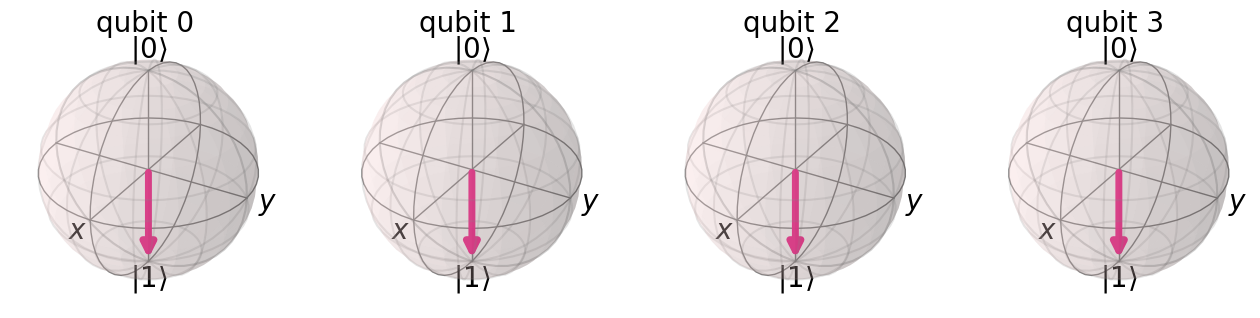

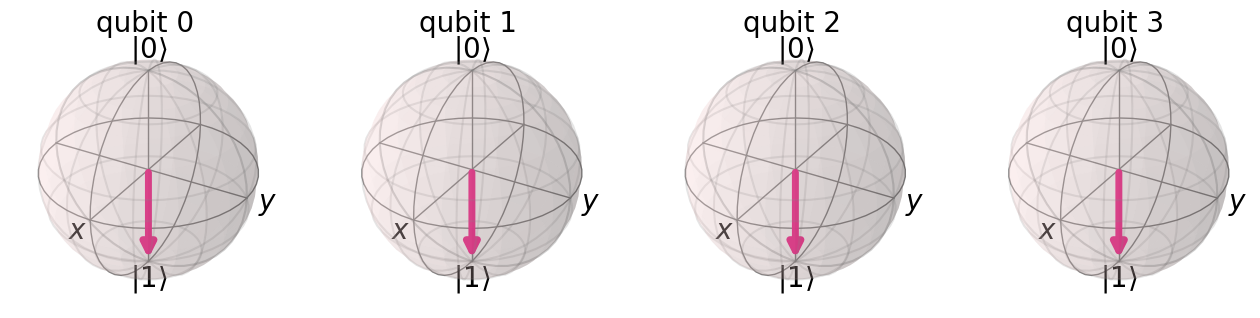

0:E(sq_4) -8.0 ravg:0.0
1:E(sq_4) -4.0 ravg:0.5
2:E(sq_4) -4.0 ravg:0.0
3:E(sq_4) -4.0 ravg:0.5
4:E(sq_4) -0.0 ravg:0.666667
5:E(sq_4) -0.0 ravg:0.676057
6:E(sq_4) -0.0 ravg:0.674287
7:E(sq_4) 0.0 ravg:0.707107
8:E(sq_4) 0.0 ravg:0.668686
9:E(sq_4) 0.0 ravg:0.106391
10:E(sq_4) 0.0 ravg:0.707107
11:E(sq_4) 4.0 ravg:0.0
12:E(sq_4) 4.0 ravg:0.5
13:E(sq_4) 4.0 ravg:1.0
14:E(sq_4) 4.0 ravg:1.0
15:E(sq_4) 4.0 ravg:0.5


In [388]:
key= 'sq_4'
idx = 14
svector = eigenvectors[key][idx].primitive
plot_bloch_multivector(svector)
# print(f"{key}:   {eigenvectors[key]}")
normed_svector, ravg = getNormedState(svector)
plot_bloch_multivector(normed_svector)
for idx in range(len(eigenvectors[key])):
    svector = eigenvectors[key][idx].primitive
    normed_svector, ravg = getNormedState(svector)
    print(f"{idx}:E({key}) {np.around(eigenvalues[key][idx],6)} ravg:{np.around(ravg,6)}")

In [1237]:
for key,H in hams.items():
    degen_list = ''
    eigenvals = eigenvalues.get(key,None)
    if eigenvals is None:
        print(f"\nCompute eigenvalues for {key}")
        result = NumPyEigensolver(k=64).compute_eigenvalues(H)
        eigenvectors[key] = result.eigenstates
        eigenvalues[key] = result.eigenvalues
        targets[key] = eigenvalues[key][0]
        eigenvals = results.eigenvalues
    unq_value, unq_counts = degeneracy(eigenvals)
    for eig in unq_value:
        degen = unq_counts[eig]
        degen_list += f"\n\t{np.around(eig,4):8.4f}:[{degen}]"
        cell = cell_list.get(key,None)
        if cell is None:
            edges = -1
        else:
            edges = len(cell.weighted_edge_list)
    print(f"\nH{key}: Edges {edges} "
          f"Eigenvalues {len(eigenvalues[key])} {degen_list}\n")
    
print(f"Targets:")
for key in hams:
    print(f"\t{key:6s} : {np.around(targets[key],8)}")


H12_12: Edges 18 Eigenvalues 128 
	-18.0000:[2]
	-16.9613:[3]
	-16.9449:[6]
	-16.9296:[6]
	-16.8098:[3]
	-16.7353:[1]
	-16.7293:[2]
	-16.5674:[2]
	-16.3117:[3]
	-16.2754:[6]
	-16.2259:[1]
	-16.0412:[6]
	-15.6539:[3]
	-15.4601:[2]
	-15.3308:[3]
	-15.3178:[5]
	-15.1668:[10]
	-15.0882:[1]
	-14.9331:[1]
	-14.9271:[6]
	-14.8826:[10]
	-14.8709:[6]
	-14.8105:[3]
	-14.6673:[6]
	-14.6577:[5]
	-14.5607:[10]
	-14.4882:[3]
	-14.4583:[5]
	-14.2980:[2]
	-13.9776:[3]
	-13.8805:[2]
	-13.8475:[1]


H12_16: Edges 18 Eigenvalues 64 
	-18.0000:[32]
	-16.9613:[17]
	-16.9449:[15]


H4_7: Edges 4 Eigenvalues 64 
	 -6.0000:[8]
	 -4.0000:[24]
	 -2.0000:[32]


H4_4: Edges 4 Eigenvalues 16 
	 -6.0000:[1]
	 -4.0000:[3]
	 -2.0000:[4]
	  2.0000:[3]
	  4.0000:[5]


H3_3: Edges 3 Eigenvalues 8 
	 -3.0000:[4]
	  3.0000:[4]


Hsq_4: Edges 4 Eigenvalues 16 
	 -8.0000:[1]
	 -4.0000:[3]
	 -0.0000:[7]
	  4.0000:[5]


Hsq_7: Edges 4 Eigenvalues 64 
	 -8.0000:[8]
	 -4.0000:[24]
	 -0.0000:[32]


H4_4_BC1: Edges -1 Eigenvalue

## Initial Ansatzs

In [540]:
myAnsatz = {}

In [545]:
def get_Alabel(A,name=None):
    if name is None:
        name = A.name
    return f"{name} n:{3} q:{A.num_qubits} p:{A.num_parameters}" 

def display_Ansatz(A):
    if isinstance(A,dict):
        for key,value in A.items():
            print(f"{get_Alabel(value)} g:{str(dict(value.count_ops()))}")
    else:
        print(f"{get_Alabel(A)} g:{str(dict(A.count_ops()))}")

A3_SU2 = EfficientSU2(3, entanglement='linear', reps=3, 
                      name='A3_SU2',skip_final_rotation_layer=True).decompose()
myAnsatz[A3_SU2.name] = A3_SU2
    
A3_SU2_opt = transpile(A3_SU2, backend=nairobi, initial_layout=qbitmap_3_to_7)
A3_SU2_opt.name = 'A3_SU2_opt'
myAnsatz[A3_SU2_opt.name] = A3_SU2_opt

A4_SU2 = EfficientSU2(4, entanglement='linear', reps=3, 
                      name='A4_SU2',skip_final_rotation_layer=True).decompose()
myAnsatz[A4_SU2.name] = A4_SU2
A4_SU2_opt = transpile(A4_SU2, backend=nairobi, initial_layout=qbitmap_4_to_7)
A4_SU2_opt.name = 'A4_SU2_opt'
myAnsatz[A4_SU2_opt.name] = A4_SU2_opt


A12_SU2 = EfficientSU2(12, entanglement='linear', reps=3, 
                       name='A12_SU2',skip_final_rotation_layer=True).decompose()
myAnsatz[A12_SU2.name] = A12_SU2
A12_SU2_opt = transpile(A12_SU2, backend=guadalupeSim, initial_layout=qbitmap_12_to_16)
A12_SU2_opt.name = 'A12_SU2_opt'
myAnsatz[A12_SU2_opt.name] = A12_SU2_opt


display_Ansatz(myAnsatz)

A3_SU2 n:3 q:3 p:18 g:{'ry': 9, 'rz': 9, 'cx': 6}
A3_SU2_opt n:3 q:7 p:18 g:{'rz': 27, 'sx': 18, 'cx': 6}
A4_SU2 n:3 q:4 p:24 g:{'ry': 12, 'rz': 12, 'cx': 9}
A4_SU2_opt n:3 q:7 p:24 g:{'rz': 36, 'sx': 24, 'cx': 16}
A12_SU2 n:3 q:12 p:72 g:{'ry': 36, 'rz': 36, 'cx': 33}
A12_SU2_opt n:3 q:16 p:72 g:{'rz': 108, 'sx': 72, 'cx': 33}


In [547]:
# Build a custom ansatz from scratch with optional starting circuit
def rotationIsing(num_qubits,qc=None,layers=3,name='rotationIsing'):
    from qiskit.circuit import Parameter
    if qc is None:
        ansatz = QuantumCircuit(num_qubits)
    else:
        ansatz = qc.copy(name=name)
        num_qubits  = qc.num_qubits
    # Mixing Layers
    j=0
    for i in range(num_qubits):
        if layers > 0:
            ansatz.rx(Parameter('θ_' + str(j)), i)
            j += 1
        if layers > 1:
            ansatz.ry(Parameter('θ_' + str(j)), i)
            j += 1
        if layers > 2:
            ansatz.rz(Parameter('θ_' + str(j)), i)
            j += 1
    return ansatz


def customSU2(num_qubits,qc=None,layers=3,name='customSU2'):
    from qiskit.circuit import Parameter
    if qc is None:
        customSU2 = QuantumCircuit(num_qubits)
    else:
        customSU2 = qc.copy(name=name)
        num_qubits = qc.num_qubits
    # Mixing Layers
    ESU2 = EfficientSU2(num_qubits, entanglement='linear', 
                        reps=layers, skip_final_rotation_layer=True).decompose()
    customSU2 = customSU2.compose(ESU2)
    return customSU2

def customAnsatz2(num_qubits,qc=None,layers=0,name='ansatz2'):
    from qiskit.circuit import Parameter
    if qc is None:
        ansatz2 = QuantumCircuit(num_qubits)
        ansatz2 = ansatz2.extend(customAnsatz1(num_qubits))
    else:
        ansatz2 = qc.copy(name=name)
        num_qubits = qc.num_qubits
    # Mixing Layers
    j = 1
    for l in range(1,layers):
        for i in range(num_qubits):
            ansatz2.rz(Parameter('θ_' + str(j)), i)
            j += 1
            ansatz2.ry(Parameter('θ_' + str(j)), i)
            j += 1
        ansatz2.cx(range(0, num_qubits-1), range(1, num_qubits))
    return ansatz2


def customAnsatz1(num_qubits,name='cust1'):
    from qiskit.circuit import Parameter
    ansatz_custom = QuantumCircuit(num_qubits,name=name)
    # build initial state
    ansatz_custom.h(range(0, num_qubits, 2))
    ansatz_custom.cx(range(0, num_qubits-1, 2), range(1, num_qubits, 2))
    # First layer
    j = 0
    for i in range(num_qubits):
        ansatz_custom.rz(Parameter('θ_' + str(j)), i)
        j += 1
        ansatz_custom.ry(Parameter('θ_' + str(j)), i)
        j += 1
    ansatz_custom.cx(range(0, num_qubits-1), range(1, num_qubits))
    return ansatz_custom


In [548]:
A3_cust1  = customAnsatz1(3,name='A3_cust1')
myAnsatz[A3_cust1.name] = A3_cust1

A3_cust1_opt = transpile(A3_cust1, backend=nairobi, initial_layout=qbitmap_3_to_7)
A3_cust1_opt.name = 'A3_cust1_opt'
myAnsatz[A3_cust1_opt.name] = A3_cust1_opt

A4_cust1  = customAnsatz1(4, name='A4_cust1')
myAnsatz[A4_cust1.name] = A4_cust1

A4_cust1_opt = transpile(A4_cust1, backend=nairobi, initial_layout=qbitmap_4_to_7)
A4_cust1_opt.name = 'A4_cust1_opt'
myAnsatz[A4_cust1_opt.name] = A4_cust1_opt

A12_cust1 = customAnsatz1(12,name='A12_cust1')
myAnsatz[A12_cust1.name] = A12_cust1

A12_cust1_opt = transpile(A12_cust1, backend=guadalupeSim, initial_layout=qbitmap_12_to_16)
A12_cust1_opt.name = 'A12_cust1_opt'
myAnsatz[A12_cust1_opt.name] = A12_cust1_opt


display_Ansatz(myAnsatz)

A3_SU2 n:3 q:3 p:18 g:{'ry': 9, 'rz': 9, 'cx': 6}
A3_SU2_opt n:3 q:7 p:18 g:{'rz': 27, 'sx': 18, 'cx': 6}
A4_SU2 n:3 q:4 p:24 g:{'ry': 12, 'rz': 12, 'cx': 9}
A4_SU2_opt n:3 q:7 p:24 g:{'rz': 36, 'sx': 24, 'cx': 16}
A12_SU2 n:3 q:12 p:72 g:{'ry': 36, 'rz': 36, 'cx': 33}
A12_SU2_opt n:3 q:16 p:72 g:{'rz': 108, 'sx': 72, 'cx': 33}
A3_cust1 n:3 q:3 p:6 g:{'cx': 3, 'rz': 3, 'ry': 3, 'h': 2}
A3_cust1_opt n:3 q:7 p:6 g:{'rz': 13, 'sx': 8, 'cx': 3}
A4_cust1 n:3 q:4 p:8 g:{'cx': 5, 'rz': 4, 'ry': 4, 'h': 2}
A4_cust1_opt n:3 q:7 p:8 g:{'rz': 16, 'sx': 10, 'cx': 8}
A12_cust1 n:3 q:12 p:24 g:{'cx': 17, 'rz': 12, 'ry': 12, 'h': 6}
A12_cust1_opt n:3 q:16 p:24 g:{'rz': 48, 'sx': 30, 'cx': 17}


# Develop Sub-lattice
### Consider the lattice consisting of Nodes 0, 1, 2, and 3

* The full lattice can be built three (3) copies of this sub-lattice
* Nodes 0, 4, and 7, the starting corners of each sub-lattice
* Impose boundary conditions between 0 <-> 4 <-> 7 <-> 0
* Solve the energy level of the sub-lattice 0 thru 4 (5 nodes)
   * Use 4 nodes (0-3)
   * Boundary conditions to map H entries from 1<->4 and 3<->4

# Boundary Conditions

Node 4 is  related to Node 0 such that

$$
    \psi_4  =K*\psi_0  \\
    K^3 = I
$$

Assuming symetric rotations around the lattice we have

$$  
   K_i =R_x(\theta_i)*R_y(\phi_i)*R_z(\lambda_i) \\ i\in [0,1,2]  \\
   \sum_{i=0}^2\theta_i = n*2\pi \quad n \in I \\
   \sum_{i=0}^2\phi_i = n*2\pi  \\
   \sum_{i=0}^2\lambda_i = n*2\pi  \\
$$
 
Simple starting points are

$$  
\begin{equation}
(1) \quad \theta_i = \phi_i = \lambda_i = 0  \\
(2) \quad \theta_i = \phi_i = \lambda_i = \frac{2\pi}{3}  \\
(3) \quad \theta_i = \phi_i = \lambda_i = \frac{4\pi}{3}  \label{eq1} \\
\end{equation}
$$

For case 1:
$$
K=I  \\
\psi_4 = \psi_0
$$

# Adding Boundary Conditions
## Add Hamiltonian entries on the boundary
Must add $XX + YY + ZZ$ on virtual edges of the sub-lattice for to Node 4
$$\psi_1 \psi_4 = \psi_1\psi_0 + \psi_1 (K*\psi_0) \\
\psi_3 \psi_4 = \psi_3 (K\psi_0) $$
For case 1, $K=I$ the additional Hamiltonian entries are:

\begin{align}
H_{case1} =~~ &1.0*(IIZZ+IIYY+IIXX)~~ + \\ &1.0*(ZIIZ+YIIY+XIIX) 
\end{align}


In [15]:
# Create the addtional terms for the Case 1 Hamiltonian
from qiskit.opflow import X, Y, Z, I
# H1_1_4 = 1.0*(I^I^Z^Z) + 1.0*(I^I^Y^Y) + 1.0*(I^I^X^X)

def BoundaryCondition(qbits,K,num_qubits):
    from qiskit.quantum_info import SparsePauliOp
    from qiskit.opflow.primitive_ops import PauliSumOp
    # Start with K = I
    coefs = [1.0, 1.0, 1.0]
    op = SparsePauliOp.from_sparse_list([("XX", qbits, coefs[0]), 
                                         ("YY", qbits, coefs[1]),
                                         ("ZZ", qbits, coefs[2])] ,num_qubits=num_qubits)
    H = PauliSumOp(op)
    return H

### H4_BC_1  -  4 Node, Case 1 Boundary Condition: K = I

In [1235]:
# Case 1  K = I
H4_BCS_C1 = BoundaryCondition([0,1],I,4) + BoundaryCondition([0,3],I,4)
hams['4_4_BC1']  =  hams['4_4'] + H4_BCS_C1
exact_result4_C1 = NumPyEigensolver(k=64).compute_eigenvalues(hams['4_4_BC1'])
targets['4_4_BC_1'] = exact_result4_C1.eigenvalues[0]

# kagome.SparsePauliPrint(H4_BCS_C1.primitive,label='Additional Terms')
print(f"Part Lattice (4 Nodes) Case 1 (K=I) eigenvalues {exact_result4_C1.eigenvalues}\n")
# kagome.SparsePauliPrint(H4_BC_1.primitive,label='Full Hamiltonian Case 1: K=I')
print(hams['4_4_BC1'])

Part Lattice (4 Nodes) Case 1 (K=I) eigenvalues [-6. -6. -6. -6. -6. -2. -2. -2.  2.  2.  2.  6.  6.  6.  6.  6.]

1.0 * ZIZI
+ 1.0 * IZZI
+ 1.0 * IZIZ
+ 1.0 * IIZZ
+ 1.0 * YIYI
+ 1.0 * IYYI
+ 1.0 * IYIY
+ 1.0 * IIYY
+ 1.0 * XIXI
+ 1.0 * IXXI
+ 1.0 * IXIX
+ 1.0 * IIXX
+ 1.0 * IIXX
+ 1.0 * IIYY
+ 1.0 * IIZZ
+ 1.0 * XIIX
+ 1.0 * YIIY
+ 1.0 * ZIIZ


### H7_BC_1  -  4 Node, 7 Qubit - Case 1 Boundary Condition: K = I

In [992]:
H4_7_BCS = BoundaryCondition([0,1],I,7) + BoundaryCondition([3,0],I,7)
H4_7_BC1 = H7 + H4_7_BCS
exact_result7_C1 = NumPyEigensolver(k=20).compute_eigenvalues(H4_7_BC1)
targets['H7_BC_1'] = exact_result7_C1.eigenvalues[0]

print(f"Part Lattice (4 Nodes) Case 1 (K=I) eigenvalues {exact_result4_C1.eigenvalues}\n")
print(H4_7_BC1)
# kagome.SparsePauliPrint(H7_BC_1.primitive,label='7 Qubit - 4 Node - Full Hamiltonian Case 1')

Part Lattice (4 Nodes) Case 1 (K=I) eigenvalues [-6. -6. -6. -6. -6. -2. -2. -2.  2.  2.  2.  6.  6.  6.  6.  6.]

1.0 * IIIZIZI
+ 1.0 * IIIIZZI
+ 1.0 * IIIIZIZ
+ 1.0 * IIIIIZZ
+ 1.0 * IIIYIYI
+ 1.0 * IIIIYYI
+ 1.0 * IIIIYIY
+ 1.0 * IIIIIYY
+ 1.0 * IIIXIXI
+ 1.0 * IIIIXXI
+ 1.0 * IIIIXIX
+ 1.0 * IIIIIXX
+ 1.0 * IIIIIXX
+ 1.0 * IIIIIYY
+ 1.0 * IIIIIZZ
+ 1.0 * IIIXIIX
+ 1.0 * IIIYIIY
+ 1.0 * IIIZIIZ


# Setup for Runs
## Data Files, Ansatz and Optimizers

In [18]:
# File Names
fnameFull     = 'FullLatticeResults.dump'
fnameSub      = 'SubLatticeResults.dump'
fnameSub3     = 'SubLatticeResults03.dump'
fnameH4_4_BC1 = 'H4_4_BC1.dump'

# --------------------- Solutions -----------------------------

# Full Lattice - Local and Cloud

### Custom Ansatz

In [ ]:
FullResults = kagome.load_customVQE(fnameFull)

In [ ]:
# Local Simulator
H = H16
target = np.around(targets[12],2)
label = f"A12 Cust1 {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A12_cust1_opt, SPSA_01, 
                                 minAnsatz=A12_cust1,
                                 timeout=120, x0=None, target=target,
                                 service=None, backend=None, 
                                 resultsList=FullResults,
                                 label=label)
kagome.save_customVQE(FullResults,fnameFull)

In [ ]:
kagome.list_results(FullResults)
FullResults[-1].show_result()

### Efficient SU2 Ansatz

In [ ]:
FullResults = kagome.load_customVQE(fnameFull)

In [ ]:
# Local Simulator
H = H16
target = np.around(targets[12],2)
label = f"A12_SU2   {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A12_SU2_opt, SPSA_01, 
                                 minAnsatz=A12_SU2,
                                 service=None, backend=None, 
                                 timeout=180, x0=None, target=-18,
                                 resultsList=FullResults,
                                 label=label )
kagome.save_customVQE(FullResults,fnameFull)

In [ ]:
# Cloud Solver
H = H16
target = np.around(targets[12],2)
label = f"A12_SU2   {SPSA_01_label}"
custom_vqe = runCustomVQE(H, A12_SU2_opt, SPSA_01,
                          minAnsatz=A12_SU2,
                          service=service, backend='simulator_statevector',
                          timeout=180, x0=None, target=-18,
                          resultsList=FullResults,
                          label=label)
kagome.save_customVQE(FullResults,fnameFull)

In [ ]:
kagome.list_results(FullResults)
FullResults[-1].show_result()

# Sub-Lattice

### Square Lattice

------------ |0101> A4_Ising_L3 --------------


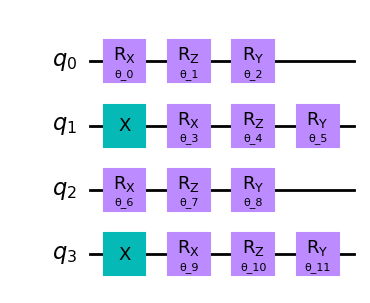

1.0 * ZZII
+ 1.0 * IZZI
+ 1.0 * ZIIZ
+ 1.0 * IIZZ
+ 1.0 * YYII
+ 1.0 * IYYI
+ 1.0 * YIIY
+ 1.0 * IIYY
+ 1.0 * XXII
+ 1.0 * IXXI
+ 1.0 * XIIX
+ 1.0 * IIXX


In [454]:
# Start with ansatz on the minimum solution
qc=QuantumCircuit(4)
qc.x(1)
qc.x(3)
A4_I_L3  = rotationIsing(4,qc=qc,name='|0101> A4_Ising_L3',layers=3)
print(f"------------ {A4_I_L3.name} --------------")
A4_I_L3.draw()
key = 'sq_4'
H = hams[key]
print(H)

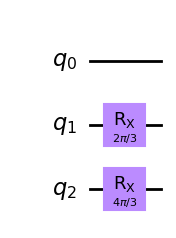

-1.5


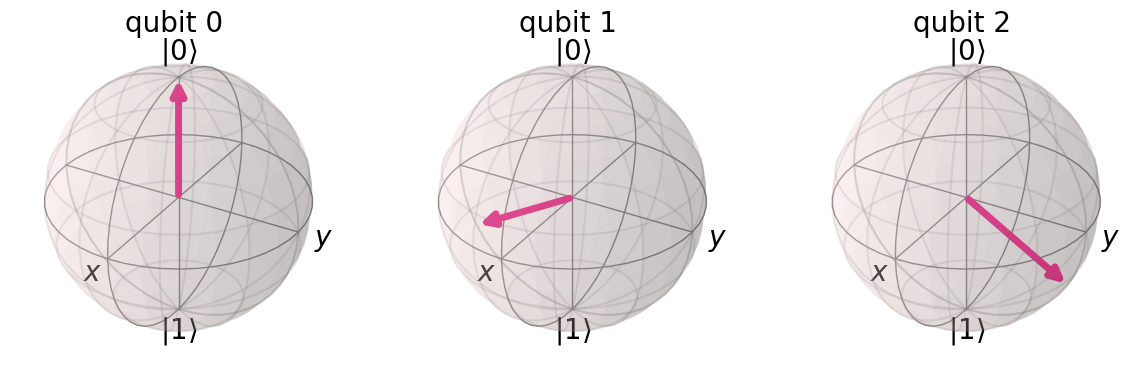

------------ |R(pi/3)> A3_Ising_L1 --------------


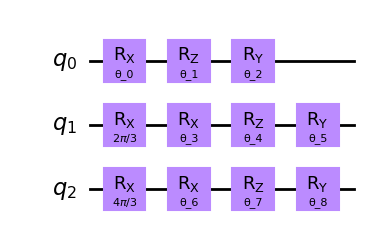

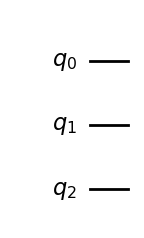

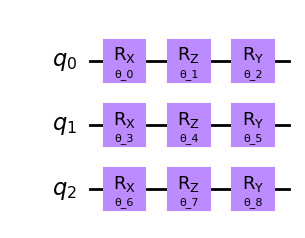

3.0


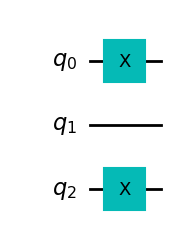

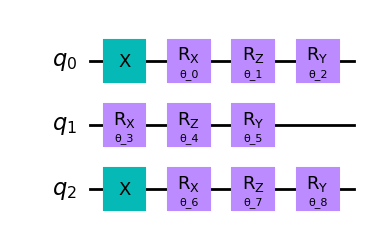

-1.0


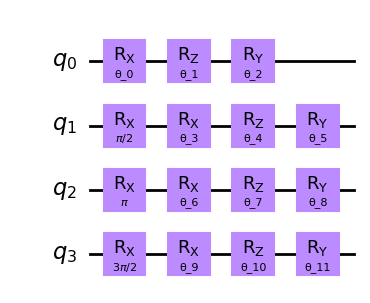

0.0
-------- A4_I5_L1 -------------


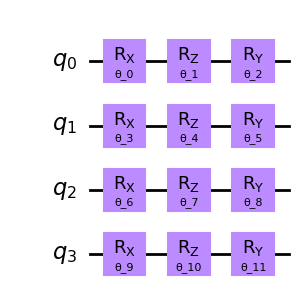

A[A4_I5_L1].expectation(sq_4) 4.0
-------- A4_I6_L1 -------------


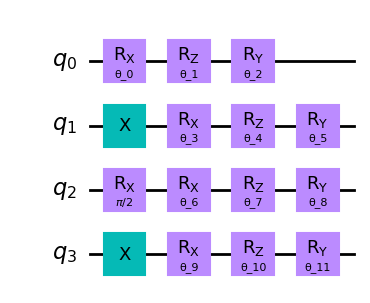

A[A4_I6_L1].expectation(4_4_BC1)=-2.0 E0=-6.0
-------- A4_SU2_X0 -------------


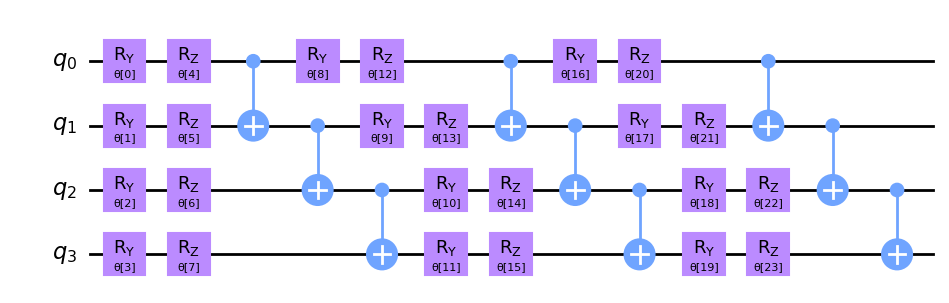

A[A4_SU2_X0].expectation(4_4_BC1)=6.0 E0=-6.0
-------- A4_SU2_X1 -------------


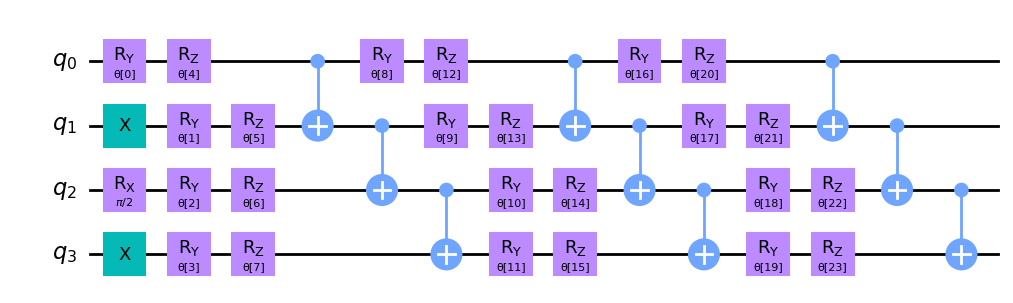

A[A4_SU2_X1].expectation(4_4_BC1)=-2.0 E0=-6.0


In [1295]:
# num_qubits,qc=None,layers=3,name='rotationIsing'
# print(r0)
# Start with ansatz on the even rotations solution
# svectors = {}
# circuits = {}
def rotationQC(nqubits, r0, name=''):
    qc=QuantumCircuit(nqubits,name=name)
    for idx in range(1,nqubits):
        _=qc.rx(idx*r0,idx)
    return qc

r0 = 2*np.pi/3.0
qc = rotationQC(3,r0,name='|R(pi/3)>')
qc.draw()
Svector_A3_I_L1 = qc2Statevector(qc)
angles = getBlochAngles(Svector_A3_I_L1)
E = Svector_A3_I_L1.expectation_value(hams['3_3'])
print(np.around(np.real(E),4))

plot_bloch_multivector(Svector_A3_I_L1)
A3_I_L1  = rotationIsing(nqubits,qc=qc,name='|R(pi/3)> A3_Ising_L1',layers=3)
myAnsatz['A3_I_L1'] = A3_I_L1
print(f"------------ {A3_I_L1.name} --------------")
A3_I_L1.draw()
key = '3_3'
H = hams[key]
# print(H)
Svector_A3_I_L1 = qc2Statevector(qc)


nqubits=3
qc0=QuantumCircuit(nqubits,name='|000>')
qc0.draw()
A3_I0_L1  = rotationIsing(nqubits,qc=qc0,name='|000> A3_Ising_L1',layers=3)
myAnsatz['A3_I0_L1'] = A3_I0_L1
Svector_A3_I0_L1 = qc2Statevector(qc0)
E = Svector_A3_I0_L1.expectation_value(hams['3_3'])
A3_I0_L1.draw()
print(np.around(np.real(E),4))


nqubits=3
qc1=QuantumCircuit(nqubits,name='|101>')
_=qc1.x(range(0, nqubits, 2))
qc1.draw()
A3_I1_L1  = rotationIsing(nqubits,qc=qc1,name='|101> A3_Ising_L1',layers=3)
myAnsatz['A3_I1_L1'] = A3_I1_L1
Svector_A3_I1_L1 = qc2Statevector(qc1)
E = Svector_A3_I1_L1.expectation_value(hams['3_3'])
A3_I1_L1.draw()
print(np.around(np.real(E),4))
# ------------------------------------------------------------------------------ #
nqubits=4
r4 = np.pi/2.0
qc2 = rotationQC(nqubits,r4,name='|R(pi/2)>')
# qc2.draw()
A4_I4_L1  = rotationIsing(nqubits,qc=qc2,name='|0xy0> A4_Ising_L1',layers=3)
myAnsatz['A4_I4_L1'] = A4_I4_L1
A4_I4_L1.draw()
Svector_A4_I4_L1 = qc2Statevector(qc2)
angles = getBlochAngles(Svector_A4_I4_L1)
E = Svector_A3_I2_L1.expectation_value(hams['sq_4'])
print(np.around(np.real(E),4))
# ------------------------------------------------------------------------------ #
Alabel = 'A4_I5_L1'
Hlabel = 'sq_4'
nqubits=4
print(f"-------- {Alabel} -------------")
circuits[Alabel] = QuantumCircuit(nqubits)
myAnsatz[Alabel] = rotationIsing(nqubits,qc=circuits[Alabel],name='|0000> {Alabel}',layers=3)
myAnsatz[Alabel].draw()
svectors[Alabel] = qc2Statevector(circuits[Alabel])
E = svectors[Alabel].expectation_value(hams[Hlabel])
print(f"A[{Alabel}].expectation({Hlabel}) {np.around(np.real(E),4)}")
# ------------------------------------------------------------------------------ #
Alabel = 'A4_I6_L1'
Hlabel = '4_4_BC1'
nqubits=4
print(f"-------- {Alabel} -------------")
circuits[Alabel] = QuantumCircuit(nqubits,name=Alabel)
_=circuits[Alabel].x([1,3])
_=circuits[Alabel].rx(np.pi/2.0,2)
myAnsatz[Alabel] = rotationIsing(nqubits,qc=circuits[Alabel],name=f'|0000> {Alabel}',layers=3)
myAnsatz[Alabel].draw()
svectors[Alabel] = qc2Statevector(circuits[Alabel])
E = svectors[Alabel].expectation_value(hams[Hlabel])
print(f"A[{Alabel}].expectation({Hlabel})={np.around(np.real(E),4)} E0={np.around(targets[Hlabel],3)}")
# ------------------------------------------------------------------------------ #
Alabel = 'A4_SU2_X0'
Hlabel = '4_4_BC1'
nqubits=4
print(f"-------- {Alabel} -------------")
circuits[Alabel] = QuantumCircuit(nqubits,name=Alabel)
myAnsatz[Alabel] = customSU2(nqubits,qc=circuits[Alabel],layers=3,name=f'|0000> {Alabel}')
myAnsatz[Alabel].draw()
svectors[Alabel] = qc2Statevector(circuits[Alabel])
E = svectors[Alabel].expectation_value(hams[Hlabel])
print(f"A[{Alabel}].expectation({Hlabel})={np.around(np.real(E),4)} E0={np.around(targets[Hlabel],3)}")
# ------------------------------------------------------------------------------ #
Alabel = 'A4_SU2_X1'
Hlabel = '4_4_BC1'
nqubits=4
print(f"-------- {Alabel} -------------")
circuits[Alabel] = QuantumCircuit(nqubits,name=Alabel)
_=circuits[Alabel].x([1,3])
_=circuits[Alabel].rx(np.pi/2.0,2)
myAnsatz[Alabel] = customSU2(nqubits,qc=circuits[Alabel],layers=3,name=f'|1x10> {Alabel}')
myAnsatz[Alabel].draw()
svectors[Alabel] = qc2Statevector(circuits[Alabel])
E = svectors[Alabel].expectation_value(hams[Hlabel])
print(f"A[{Alabel}].expectation({Hlabel})={np.around(np.real(E),4)} E0={np.around(targets[Hlabel],3)}")

In [1325]:
# fnameFull     = 'FullLatticeResults.dump'
# fnameSub      = 'SubLatticeResults02.dump'   # Results for the sq_4 analysis
# fnameSub3 = 'SubLatticeResults03.dump'
fnameH4_4_BC1 = 'H4_4_BC1.dump'
fnameH4_4_BCSV = 'H4_4_BCSV.dump'
SvectorResults = []
SvectorResults.append(SubResults[-1])
# SubResults = kagome.load_customVQE(fnameH4_4_BC1)
# if len(SubResults) == 0:
#     print(f"{fnameSub} empty; Clearing init_points")
#     init_points.clear()
# SubResults = []

In [1343]:
def getX0(p_idx,curCache):
    if isinstance(p_idx,int) and (p_idx > 0) and (p_idx <= len(curCache)):
        x0 = curCache[p_idx].initial_point
    elif isinstance(p_idx,str) and (p_idx == '0'):
        x0 = 0
    else:
        x0 = None
    return x0

In [1381]:
optimizers={}
# Optimizers
from qiskit.algorithms.optimizers import SPSA
optimizers['01'] = {'opt': SPSA(maxiter=75), 'label':'SPSA(75)' }
optimizers['02'] = {'opt': SPSA(maxiter=75,callback=kagome.SPSA_callback), 
                    'label':'SPSA(75,cb)' }
optimizers['03'] = {'opt': SPSA(maxiter=75,callback=kagome.SPSA_callback,blocking=True),
                    'label':'SPSA(75,cb,block)' }
optimizers['04'] = {'opt': SPSA(maxiter=150,callback=kagome.SPSA_callback),
                    'label':'SPSA(150,cb)' }
optimizers['05'] = {'opt': SPSA(maxiter=150,callback=kagome.SPSA_callback,blocking=True),
                    'label':'SPSA(150,cb,block)' }
optimizers['06'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback),
                    'label':'SPSA(300,cb)' }
optimizers['07'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback,blocking=True),
                    'label':'SPSA(300,cb,block)' }
optimizers['08'] = {'opt': SPSA(maxiter=150,callback=kagome.SPSA_callback,trust_region=True),
                    'label':'SPSA(150,cb,trust)' }
optimizers['09'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback,trust_region=True),
                    'label':'SPSA(300,cb,trust)' }
optimizers['10'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback,second_order=True),
                    'label':'SPSA(300,cb,O(2)' }
optimizers['11'] = {'opt': SPSA(maxiter=100,callback=kagome.SPSA_callback),
                    'label':'SPSA(100,cb)' }
optimizers['12'] = {'opt': SPSA(maxiter=100,callback=kagome.SPSA_callback,trust_region=True),
                    'label':'SPSA(100,cb,trust)' }

In [ ]:
# Results cache and storage
fname    = fnameH4_4_BCSV
# kagome.save_results([],fname)
curCache = kagome.load_results(fname)
#------------- Problem Setup ----------------#
#--- Hamiltonian ---
Hkey = '4_4_BC1'
target = np.around(targets[Hkey],2)
#--- Ansazt ---
Akey = 'A4_SU2_X1'   # A4_I6_L1  : A4_SU2_X0 : A4_SU2_X1
miniAnsatz = myAnsatz[Akey]   # Same as ansatz, no ancially qbits yet
#--- Runtime ---
service = service # None  : service
backend = 'simulator_statevector' # None  : ibm_oslo  : simulator_statevector
#--- Optimizer ---
Okey = '11'
#--- X0 (initial point for optimizer)
pt_idx = ''
x0 = getX0(pt_idx,curCache)  # ['0'] -> 0 vector; [int] -> initial point from cache; else -> Random
label = f"H:{key} A:{ansatz.name} \nOpt:{optimizers[Okey]['label']} x0={p_idx} T={target}"

if 1:
    custom_vqe = kagome.runCustomVQE(hams[Hkey], myAnsatz[Akey], optimizers[Okey]['opt'], 
                                 miniAnsatz=miniAnsatz,
                                 timeout=None, x0=x0, target=target,
                                 service=service, backend=backend,
                                 resultsList=curCache,
                                 label=label )
    kagome.save_results(curCache,fname)
else: 
    print(label)

Loaded 3 results from H4_4_BCSV.dump
H:4_4_BC1 A:|1x10> A4_SU2_X1 
Opt:SPSA(100,cb) x0=Random T=-6.0 3 simulator_statevector SPSA


3 results cached: Results[-1]
slope(25) = 0.044%
kept=100.0% n=300  rejects=0
Minimum computed n=295 -5.98518404
Computed ground state energy: -5.9849208582
Expected ground state energy: -6.0000000000
Relative error: 0.25131903%


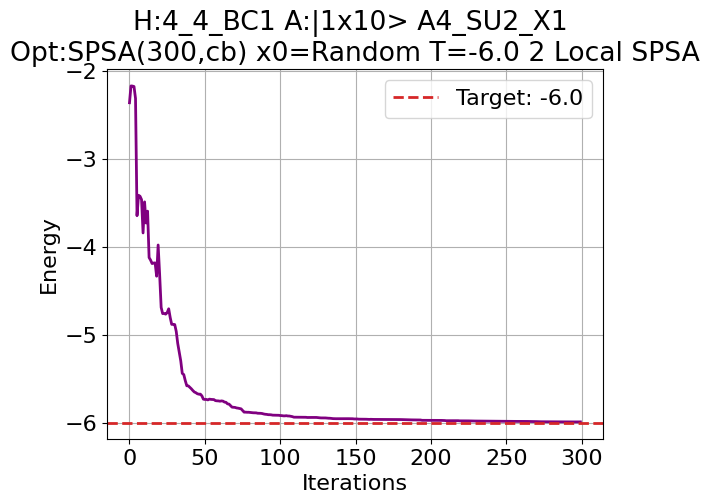

In [1429]:
idx = -1
slope_div = 12
curResult = curCache[idx]
print(f"{len(curCache)} results cached: Results[{idx}]")
spsa_data = curResult.SPSA_callback_data
if spsa_data is not None:
    Xdata, Fdata, accepts = parse_callback(spsa_data)
    if slope_div < 0:
        npoints = int(-1*slope_div)
    else:
        npoints = int(len(Fdata)/slope_div)
    print(f"slope({npoints}) = {np.around(linear_slope(Fdata,npoints,scale=-1000),3)}%")
show_callback(curResult)

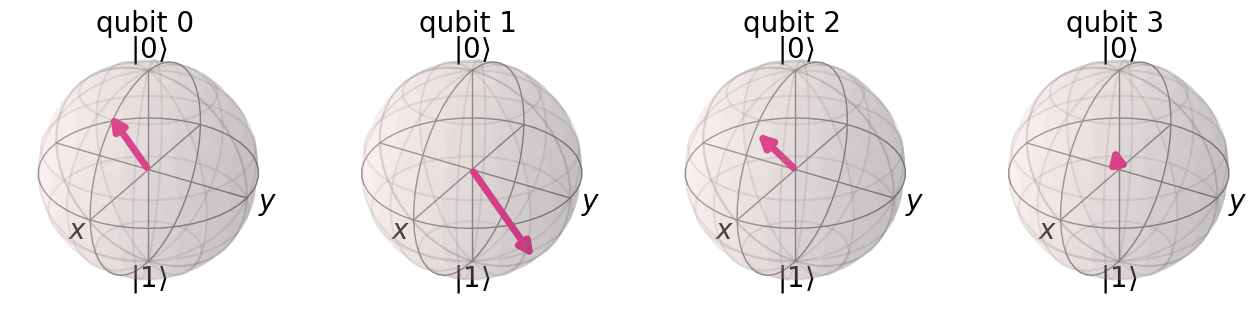

H:4_4_BC1 A:|0000> A4_I6_L1 
Opt:SPSA(300,cb,trust) x0=Random T=-6.0 1 Local SPSA: -2.96213 Initial    State Energy Level [Bloch(r)=1.0]
---------------------
H:4_4_BC1 A:|0000> A4_I6_L1 
Opt:SPSA(300,cb,trust) x0=Random T=-6.0 1 Local SPSA: -2.96213 Normalized State Energy Level [Fidelity=1.0]


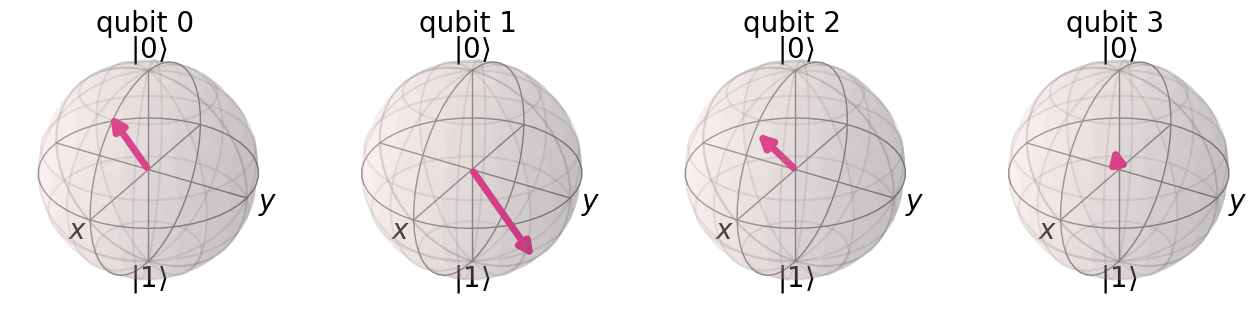

[ 0.56553581 -0.06982928  0.8217622 ]
[ 0.11565397  0.72885014 -0.67483452]
[-0.59961186 -0.79388921 -0.10102243]
[-0.80566159 -0.52621273 -0.27204699]


In [1275]:
idx = -1
myList = SubResults
custom_vqe=myList[idx]

# kagome.list_results(myList)

plot_bloch_multivector(VQE2MiniSvector(custom_vqe))
displayNormedData(custom_vqe,nqubits=4)

Svector_normed,_= getNormedState(custom_vqe)
coords=getCoords(Svector_normed)
for q_coords in coords:
    print(np.real(q_coords))

In [1379]:
def show_callback(custom_vqe,prec=8):
    spsa_data = custom_vqe.SPSA_callback_data
    if spsa_data is None or len(spsa_data) == 0:
        print("No SPSA Callback Data Available")
        Fdata = custom_vqe._callback_data
    else:
        Xdata, Fdata, accepts = parse_callback(spsa_data)
        print(f"kept={np.around(100*accepts[0]/(accepts[0]+accepts[1]),1)}% n={len(Fdata)}  rejects={accepts[1]}")

    eigenvalue = custom_vqe._result.eigenvalue
    print(f"Minimum computed n={np.argmin(Fdata)} {np.around(min(Fdata),prec)}")
    print(f'Computed ground state energy: {eigenvalue:.10f}')
    plt.title(custom_vqe._label)
    plt.plot(Fdata, color='purple', lw=2)
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    if custom_vqe._target is not None:
        rel_error = abs((custom_vqe._target - eigenvalue) / custom_vqe._target)
        print(f'Expected ground state energy: {custom_vqe._target:.10f}')
        print(f'Relative error: {np.around(100*rel_error,8)}%')
        plt.axhline(y=custom_vqe._target, color="tab:red", ls="--", lw=2, 
                    label="Target: " + str(custom_vqe._target))
    else:
        plt.axhline(y=eigenvalue, color="tab:red", ls="--", lw=2, label="Target: None" )
    plt.legend()
    plt.grid()
    plt.show()
    

def parse_callback(spsa_data):
    # Flatten the data for plotting
    (Fx,xvals,steps,accept,nF,Xdata,Fdata,Sdata,Ndata) = ([],[],[],[],[],[],[],[],[])
    accepts = [0,0]
    for curData in spsa_data:
        Fx.append(curData['Fx'])
        xvals.append(curData['x'])
        steps.append(curData['stepSize'])
        accept.append(curData['accepted'])
        nF.append(curData['n'])
        if curData['accepted']:
            Xdata.append(curData['x'])
            Fdata.append(curData['Fx'])
            Sdata.append(curData['stepSize'])
            Ndata.append(curData['n'])
            accepts[0] += 1
        else:
            accepts[1] += 1
            
    return Xdata, Fdata, accepts

# show_callback(SubResults[-1])


In [972]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Gaussian function
def Gauss(x, A, B):
    y = A*np.exp(-1*B*x**2)
    return y
def Exp(x,A,B):
    return A*np.exp(-1*B*x)

def Linear(x,A,B):
    return A*x + B

def linear_slope(data,npoints,scale=None):
    if npoints < len(data):
        ydata = data[-npoints:]
    else:
        ydata = data
    xdata = np.array(range(len(ydata)))
        
    parameters, covariance = curve_fit(Linear, xdata, ydata)
    if scale is None:
        return parameters[0]
    elif scale > 0:
        return scale*parameters[0]
    else: # Scale as % delta step
        return 100*parameters[0]*ydata[-1]

### A3 SU2 - Local

In [411]:
SubResults = kagome.load_customVQE(fnameSub)

Loaded 3 results


In [ ]:
# Local Simulation
H = H3
target = np.around(targets[3],2)
label = f"A3_SU2   {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A3_SU2_opt, SPSA_01, 
                                 miniAnsatz=A3_SU2,
                                 timeout=180, x0=None, target=target,
                                 service=None, backend=None,
                                 resultsList=SubResults,
                                 label=label )
kagome.save_customVQE(SubResults,fnameSub)

Computed ground state energy: -4.4539417958
Expected ground state energy: -6.0000000000
Relative error: 25.76763674%


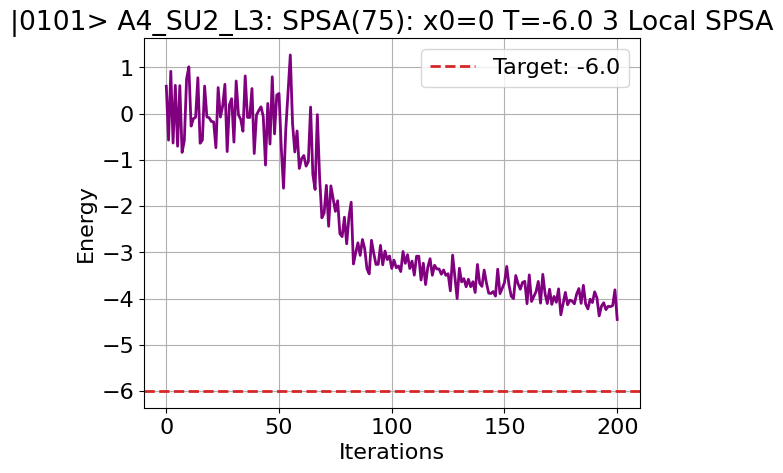

In [441]:
SubResults[-1].show_result()

In [ ]:
# Local Simulation
H = H3
target = np.around(targets[3],2)
label = f"A3_cust1 {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A3_cust1_opt, SPSA_01,
                                 miniAnsatz=A3_cust1,
                                 timeout=180, x0=None, target=target,
                                 service=None, backend=None,
                                 resultsList=SubResults,
                                 label=label )
kagome.save_customVQE(SubResults,fnameSub)

In [ ]:
# Cloud Simulation
H = H3
target = np.around(targets[3],2)
label = f"A3_SU2 {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A3_SU2_opt, SPSA_01, 
                                 minAnsatz=A3_SU2,
                                 timeout=180, x0=None, target=target,
                                 service=service, backend='simulator_statevector',
                                 resultsList=SubResults,
                                 label=label )
kagome.save_customVQE(SubResults,fnameSub)

0: 'A3_SU2   SPSA(75) 0 Local SPSA' 	Computed: -2.982	Target:   -3.0	Error 0.595%
1: 'A3_SU2   SPSA(75) 1 Local SPSA' 	Computed: -2.931	Target:   -3.0	Error 2.308%
2: 'A3_SU2   SPSA(75) 2 Local SPSA' 	Computed: -2.993	Target:   -3.0	Error 0.231%


Computed ground state energy: -2.9930771422
Expected ground state energy: -3.0000000000
Relative error: 0.23076193%


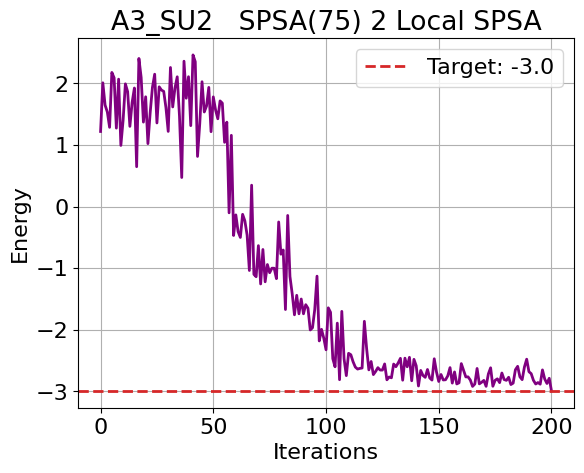

In [412]:
kagome.list_results(SubResults)
SubResults[-1].show_result()

### A4 Custom Ansatz - Local

In [ ]:
SubResults = kagome.load_customVQE(fnameSub)

In [ ]:
# Local Simulation
H = H7_BC_1
target = targets[4]
label = f"A4_cust1 {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A4_cust1_opt, SPSA_01, 
                                 minAnsatz=A4_cust1,
                                 timeout=180, x0=None, target=target,
                                 service=None, backend=None,
                                 resultsList=SubResults,
                                 label=label )
kagome.save_customVQE(SubResults,fnameSub)

In [ ]:
kagome.list_results(SubResults)
SubResults[-1].show_result()

### Efficient SU2 Ansatz - Local

In [ ]:
SubResults = kagome.load_customVQE(fnameSub)

In [ ]:
# Local Simulation
H = H7
target = targets[4]
label =f"A4_SU2   {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A4_SU2_opt, SPSA_01, 
                                 minAnsatz=A4_SU2,
                                 timeout=180, x0=None, target=target,
                                 service=None, backend=None, 
                                 resultsList=SubResults,
                                 label=label)
kagome.save_customVQE(SubResults,fnameSub)

In [ ]:
kagome.list_results(SubResults)
SubResults[-1].show_result()

## Efficient SU2 - Cloud

In [ ]:
SubResults = kagome.load_customVQE(fnameSub)

In [ ]:
# Cloud Solution
H = H7
target = targets[4]
label =f"A4_SU2   {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A4_SU2_opt, SPSA_01, 
                                 minAnsatz=A4_SU2,
                                 service=service, backend='simulator_statevector', 
                                 timeout=180, x0=None, target=target,
                                 resultsList=SubResults,
                                 label=label)
kagome.save_customVQE(SubResults,fnameSub)

In [ ]:
kagome.list_results(SubResults)
SubResults[4].show_result()

# Build Ansantz Starting Point

In [ ]:
SubResults[0]._circuit.draw('latex')

In [1064]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_bloch_multivector

def qc2Statevector(qc):
    from qiskit import Aer
    qc1 = qc.copy()
    sim = Aer.get_backend('aer_simulator')
    qc1.save_statevector()
    result = sim.run(qc1).result()
    state_vector = result.get_statevector()
    return state_vector
    
def VQE2MiniSvector(custom_vqe):
    from qiskit import Aer
    sim = Aer.get_backend('aer_simulator')
    qc = custom_vqe.get_attr('miniAnsatz').assign_parameters(custom_vqe._result.optimal_parameters)
    return qc2Statevector(qc)
    
def VQE2Statevector(custom_vqe):
    from qiskit import Aer
    sim = Aer.get_backend('aer_simulator')
    qc = custom_vqe._circuit.assign_parameters(custom_vqe._result.optimal_parameters)
    return qc2Statevector(qc)

def getBlochCoords(state_vector,qubit,num_qubits=None):
    if num_qubits is None:
        num_qubits = len(state_vector.dims())
    if qubit >= num_qubits:
        return None

    from qiskit.quantum_info import SparsePauliOp
    Xop = SparsePauliOp.from_sparse_list([("X", [qubit], 1)], num_qubits=num_qubits)
    Yop = SparsePauliOp.from_sparse_list([("Y", [qubit], 1)], num_qubits=num_qubits)
    Zop = SparsePauliOp.from_sparse_list([("Z", [qubit], 1)], num_qubits=num_qubits)
    x = state_vector.expectation_value(Xop)
    y = state_vector.expectation_value(Yop)
    z = state_vector.expectation_value(Zop)
    return [x,y,z]

def getBlochAngles(state_vector):
    angles = []
    num_qubits = len(state_vector.dims())
    for qbit in range(num_qubits):
        coords = getBlochCoords(state_vector,qbit)
        (r,theta,phi) = cart2bloch(coords)
        angles.append([theta,phi,r])
    return angles

def getCoords(state_vector, num_qubits=None):
    coords = []
    if num_qubits is None:
        num_qubits = len(state_vector.dims())
    for qbit in range(num_qubits):
        coords.append(getBlochCoords(state_vector,qbit,num_qubits=num_qubits))
    return coords

def cart2bloch(pt):
    (x,y,z) = np.real(pt)
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    theta = np.arctan2(hxy,z)
    phi = np.arctan2(y, x)
    return r, theta, phi

def bloch2cart(pt):
    (r,theta,phi) = np.real(pt)
    xy = r*np.sin(theta)
    x  = xy*np.cos(phi)
    y  = xy*np.sin(phi)
    z  = r*np.cos(theta)
    return x, y, z

def bloch2circuit(angles,nqubits):
    qc = QuantumCircuit(nqubits)
    if len(angles) < nqubits:
        nqubits = len(angles)
    for nbit in range(nqubits):
        (theta, phi,r) = angles[nbit]
        qc.ry(theta,nbit)
        qc.rz(phi,nbit)
    return qc

def bloch2Statevector(angles,nqubits=None):
    if nqubits is None:
        nqubits = len(angles)
    qc = bloch2circuit(angles,nqubits)
    return Statevector(qc)

def getNormedState(custom_vqe,nqubits=None):
    if isinstance(custom_vqe,Statevector):
        init_svector = custom_vqe
    else:
        init_svector = VQE2Statevector(custom_vqe)
    angles = getBlochAngles(init_svector)
    normed_svector = bloch2Statevector(angles,nqubits=nqubits)
    if nqubits is None:
        nqubits = len(angles)
    ravg = 0
    for idx in range(nqubits):
        (theta, phi, r) = angles[idx]
        ravg += r**2
    ravg = np.sqrt(ravg/nqubits) 
    
    return normed_svector, ravg


In [ ]:
import jTools
jTools.cellOutputAll()

In [142]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict

def removeIdleQbits(qc):
    dag = circuit_to_dag(qc)

    idle_wires = list(dag.idle_wires())
    for w in idle_wires:
        dag._remove_idle_wire(w)
        dag.qubits.remove(w)

    dag.qregs = OrderedDict()

    return dag_to_circuit(dag)

def SvectorPurity(svector):
    return DensityMatrix(svector).purity()


In [163]:
def displayNormedData(custom_vqe,H=None,nqubits=None):
    from qiskit.quantum_info import state_fidelity
    
    svector = VQE2Statevector(custom_vqe)
    if H is None:
        H=custom_vqe.get_attr('H')
    expSvector = np.real(svector.expectation_value(H))
    normed_svector, ravg = getNormedState(custom_vqe)
    coords = np.real(getCoords(normed_svector))
    expNormed = np.real(normed_svector.expectation_value(H))
    fidelity = state_fidelity(svector,normed_svector)
    print(f"{myList[idx].label}: {np.around(expSvector,5)} "
          f"Initial    State Energy Level [Bloch(r)={np.around(ravg,3)}]")
    print("---------------------")
    print(f"{myList[idx].label}: {np.around(expNormed,5)} "
          f"Normalized State Energy Level [Fidelity={np.around(fidelity,3)}]")
    if nqubits is not None:
        normed_svector, ravg = getNormedState(custom_vqe,nqubits=nqubits)

    return plot_bloch_multivector(normed_svector)

In [130]:
SubResults = kagome.load_customVQE(fnameSub)
FullResults = kagome.load_customVQE(fnameFull)

Loaded 1 results
Loaded 4 results


0: 'A3_SU2   SPSA(75) 2 Local SPSA' 	Computed: -2.993	Target:   -3.0	Error 0.231%




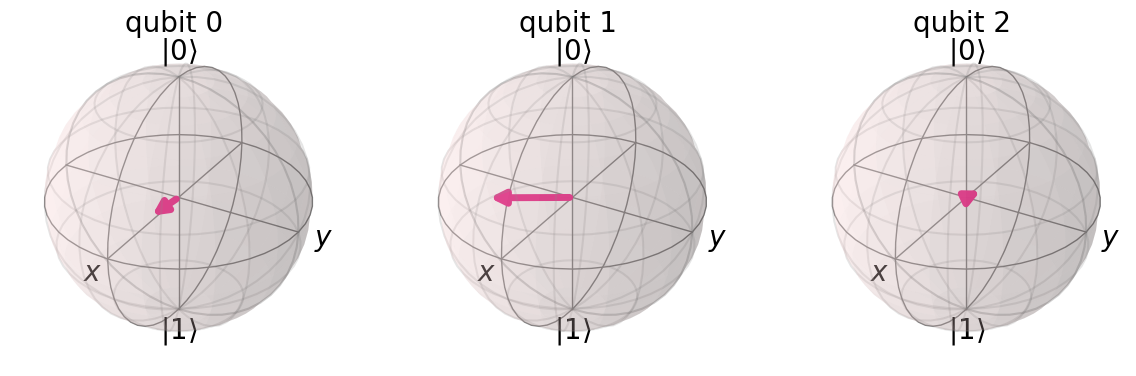

A3_SU2   SPSA(75) 2 Local SPSA: -2.99308 Initial    State Energy Level [Bloch(r)=0.825]
---------------------
A3_SU2   SPSA(75) 2 Local SPSA: -0.79617 Normalized State Energy Level [Fidelity=0.546]


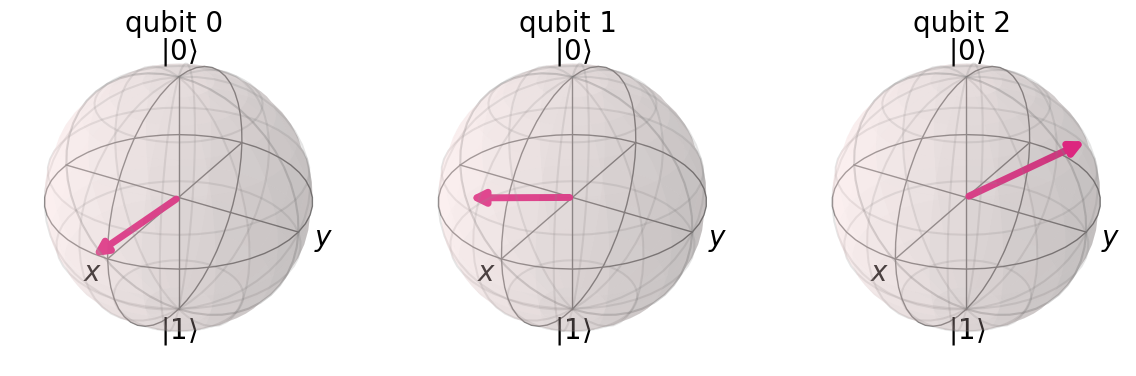

In [184]:
from jTools import cellOutputAll
cellOutputAll()
idx = -1
myList = SubResults
custom_vqe=myList[idx]

kagome.list_results(custom_vqe)

plot_bloch_multivector(VQE2MiniSvector(custom_vqe))
displayNormedData(custom_vqe,nqubits=3)

In [48]:
kagome.list_results(SubResults)

0: 'A4_cust1 SPSA(75) 0 Local SPSA' 	Computed: -2.245	Target:   -6	Error 62.585%
1: 'A4_SU2   SPSA(75) 1 Local SPSA' 	Computed: -3.475	Target:   -6	Error 42.077%
2: 'A4_cust1 SPSA(75) 2 Local SPSA' 	Computed: -2.247	Target:   -6	Error 62.554%
3: 'A4_SU2   SPSA(75) 3 Local SPSA' 	Computed: -5.154	Target:   -6	Error 14.099%
4: 'A3_SU2 SPSA(75) 4 Local SPSA' 	Computed: -2.96	Target:   -6	Error 50.661%
5: 'A3_SU2   SPSA(75) 5 Local SPSA' 	Computed: -2.937	Target:   -6	Error 51.049%
6: 'A3_SU2   SPSA(75) 6 Local SPSA' 	Computed: -2.979	Target:   -6	Error 50.345%
7: 'A3_SU2   SPSA(75) 7 Local SPSA' 	Computed: -2.949	Target:   -6	Error 50.849%
8: 'A3_cust1 SPSA(75) 8 Local SPSA' 	Computed: -1.732	Target:   -6	Error 71.136%
9: 'A3_SU2   SPSA(75) 9 Local SPSA' 	Computed: -2.958	Target:   -3.0	Error 1.409%
10: 'A3_cust1 SPSA(75) 10 Local SPSA' 	Computed: -1.731	Target:   -3.0	Error 42.3%
11: 'A4_cust1 SPSA(75) 11 Local SPSA' 	Computed: -2.219	Target:   -6.0	Error 63.023%
12: 'A4_SU2   SPSA(75) 1

In [1421]:
import importlib
importlib.reload(kagome)

<module 'kagome' from '/home/richard/src/qiskit-notebooks/Qiskit-Challenges/open-science-prize-2022/kagome.py'>